In [36]:
#importing packages for data manipulation
import pandas as pd
import numpy as np

#import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#import packages for data preprocessing

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,classification_report

#import packages for ML
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

In [2]:
#now we load the data

df=pd.read_csv('Data/tiktok_dataset.csv')
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [3]:
df.shape

(19382, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [5]:
#we are going drop the columns that we do not need in this case
df.drop(columns=['#','video_id'],axis=1,inplace=True)
df.head()

,claim_status,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,claim,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,claim,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,claim,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,claim,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,claim,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


now we do some data cleaning

In [6]:
#check for missing data
df.isna().any(axis=1).sum()

298

In [7]:
df.dropna(axis=0,inplace=True)
df.isna().any(axis=1).sum()

0

In [8]:
#change the text column to numerical
df['video_transcription_text']=df['video_transcription_text'].str.len()
df.head()

,claim_status,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,claim,59,97,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,claim,32,107,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,claim,31,137,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,claim,25,131,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,claim,19,128,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [9]:
#check for duplicates
df.duplicated().sum()

0

now we do some EDA

In [10]:
df['claim_status'].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

<Axes: xlabel='video_transcription_text', ylabel='Count'>

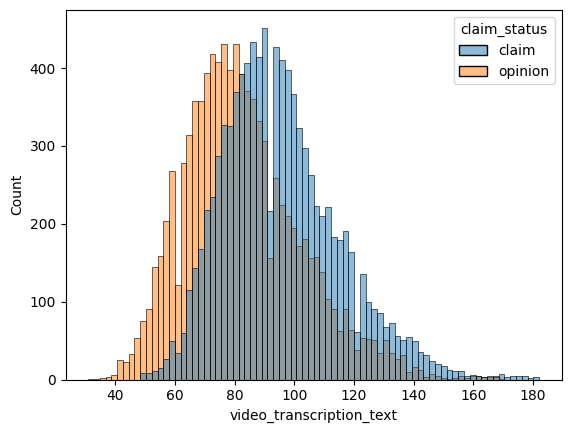

In [11]:
sns.histplot(data=df,x='video_transcription_text',hue='claim_status')

In [12]:
#check for the average of text transcription length
df.groupby(['claim_status'])[['video_transcription_text']].mean()

,video_transcription_text
claim_status,
claim,95.376978
opinion,82.722562


now we change the objects to numerical values

In [13]:
df.dtypes

claim_status                 object
video_duration_sec            int64
video_transcription_text      int64
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

In [14]:
#column claim_status, verified_status and author_ban_status should be converted

#since claim_status is our target we can juts assigned it to y variable 
y=df['claim_status'].replace({'opinion':0,
                              'claim':1})
# now we assign the other columns to our features X df
X=df.drop('claim_status',axis=1)

X=pd.get_dummies(X,columns=['verified_status','author_ban_status'],drop_first=True)
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,97,343296.0,19425.0,241.0,1.0,0.0,False,False,True
1,32,107,140877.0,77355.0,19034.0,1161.0,684.0,False,False,False
2,31,137,902185.0,97690.0,2858.0,833.0,329.0,False,False,False
3,25,131,437506.0,239954.0,34812.0,1234.0,584.0,False,False,False
4,19,128,56167.0,34987.0,4110.0,547.0,152.0,False,False,False


In [15]:
#check the type of our columns 
print(X.dtypes)
print(y.dtypes)

video_duration_sec                  int64
video_transcription_text            int64
video_view_count                  float64
video_like_count                  float64
video_share_count                 float64
video_download_count              float64
video_comment_count               float64
verified_status_verified             bool
author_ban_status_banned             bool
author_ban_status_under review       bool
dtype: object
int64


In [16]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: claim_status, dtype: int64

let us create our train and val and test dataset

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)
# let us create our val dataset
X_tr, X_val, y_tr, y_val = train_test_split(X_train,
                                            y_train,
                                            train_size=0.75,
                                            random_state=42)

In [18]:
X_train.shape ,X_test.shape ,X_val.shape ,y_train.shape ,y_test.shape ,X_tr.shape ,X_val.shape ,y_tr.shape ,y_val.shape 

((15267, 10),
 (3817, 10),
 (3817, 10),
 (15267,),
 (3817,),
 (11450, 10),
 (3817, 10),
 (11450,),
 (3817,))

now we create our models with the hyperparams

In [25]:
RF=RandomForestClassifier(random_state=0)

cv_RF_params = {'max_depth':[5,7,None],
                'max_features':[0.3,0.6],
                'max_samples':[0.7],
                'min_samples_leaf':[1,2],
                'min_samples_split':[2,3],
                'n_estimators':[75,100,200]
}


scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_RF=GridSearchCV(RF,cv_RF_params,scoring=scoring ,cv=5, refit='recall')


In [26]:
%%time
cv_RF.fit(X_tr,y_tr)

CPU times: total: 2min 4s
Wall time: 8min 29s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [27]:
cv_RF.best_score_

0.9913766326500252

In [28]:
cv_RF.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

now lets bulid our XGBoost model

In [29]:
xbg=XGBClassifier(objective='binary:logistic',random_state=0)

#we create the hyperparameters

cv_xgb_params= {'max_depth':[4,8,12],
                'min_child_weight':[3,5],
                'learning_rate':[0.01,0.1],
                'n_estimators':[300,500]
                }
scoring = ['accuracy', 'precision', 'recall', 'f1']

xbg_cv=GridSearchCV(xbg, cv_xgb_params, scoring=scoring , cv=5, refit='recall')

In [30]:
%%time
xbg_cv.fit(X_tr,y_tr)

CPU times: total: 4min 19s
Wall time: 30 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [31]:
xbg_cv.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [32]:
xbg_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 3,
 'n_estimators': 500}

In [33]:
xbg_cv.best_score_

0.9901695873374787

lets evaluate the model using our val dataset

first we start with random forest model

In [34]:
y_val_pred= cv_RF.predict(X_val)

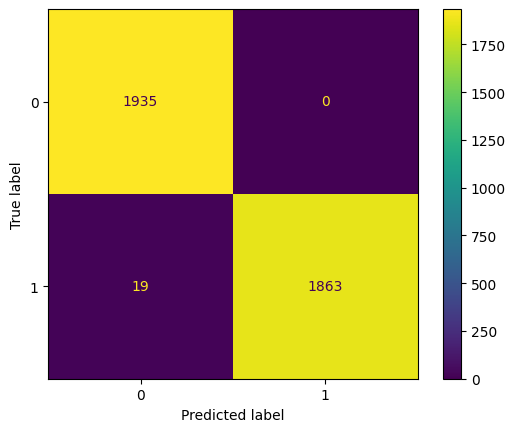

In [35]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_val_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [39]:
target_lables=['opinion','claim']
print(classification_report(y_true=y_val,y_pred=y_val_pred,target_names=target_lables))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1935
       claim       1.00      0.99      0.99      1882

    accuracy                           1.00      3817
   macro avg       1.00      0.99      1.00      3817
weighted avg       1.00      1.00      1.00      3817



now lets do the same but for our XGBoost model

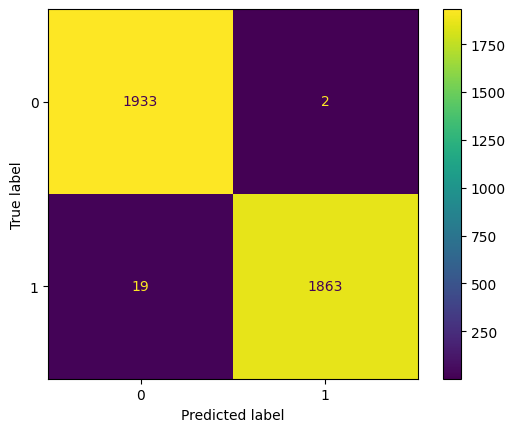

In [40]:
y_val_pred=xbg_cv.predict(X_val)
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_val_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [41]:
print(classification_report(y_true=y_val,y_pred=y_val_pred,target_names=target_lables))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1935
       claim       1.00      0.99      0.99      1882

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



now we shall evaluate our models on the test data

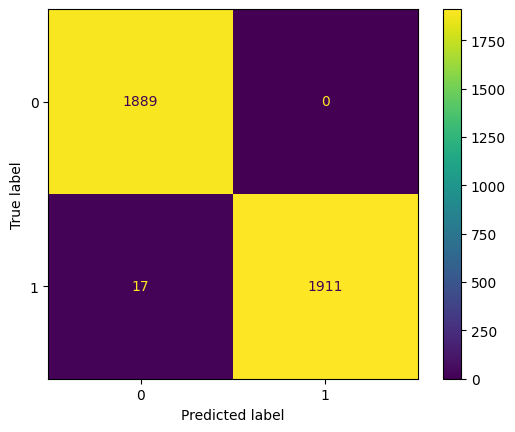

In [42]:
# RF model
y_pred_rf=cv_RF.best_estimator_.predict(X_test)
log_cm = confusion_matrix(y_test, y_pred_rf)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

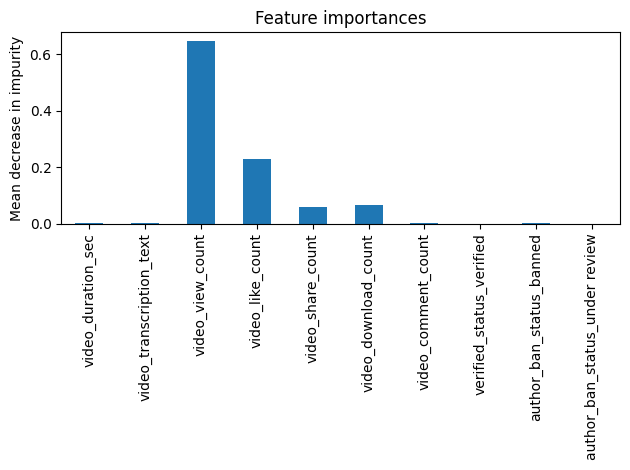

In [43]:
importances = cv_RF.best_estimator_.feature_importances_
xgb_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
xgb_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

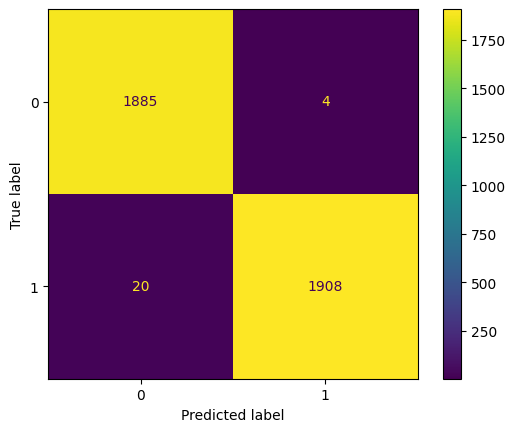

In [44]:
y_pred_xgb=xbg_cv.best_estimator_.predict(X_test)
log_cm = confusion_matrix(y_test, y_pred_xgb)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

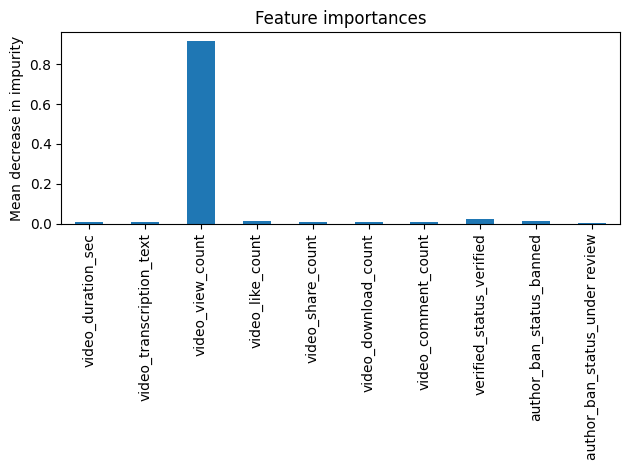

In [45]:
importances = xbg_cv.best_estimator_.feature_importances_
xgb_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
xgb_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [46]:
print(classification_report(y_true=y_test,y_pred=y_pred_rf,target_names=target_lables))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1889
       claim       1.00      0.99      1.00      1928

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



In [47]:
print(classification_report(y_true=y_test,y_pred=y_pred_xgb,target_names=target_lables))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1889
       claim       1.00      0.99      0.99      1928

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817

